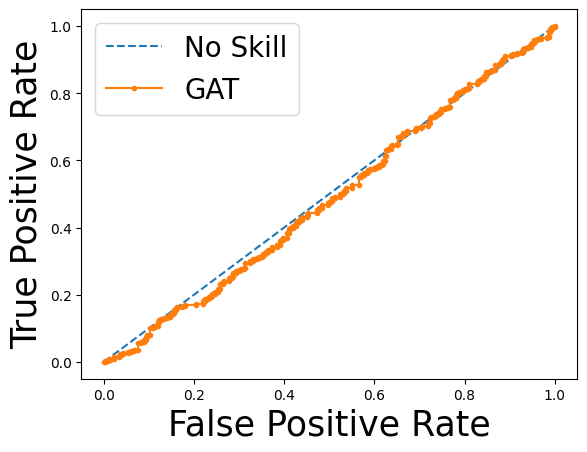

Best Threshold=0.432667, G-Mean=0.492


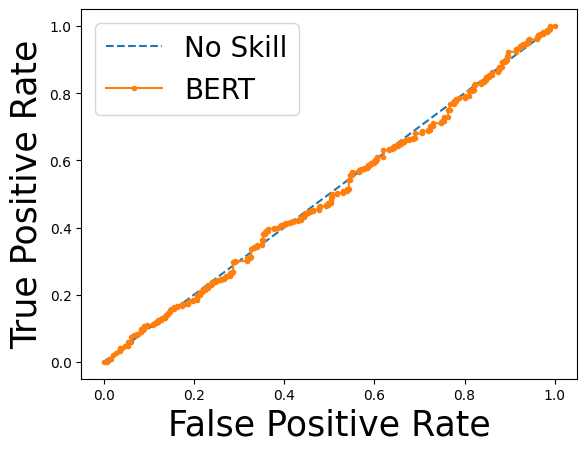

Best Threshold=0.764300, G-Mean=0.505


In [14]:
'''
Ensemble Prediction Classifier

Code Adapted from Alva Yan's Post-Covid Sentiment Analysis,
https://github.com/AlvaYan/postCOVIDSentiAnalysis, and
https://github.com/AlvaYan/Sentiment-Analysis-GNN-During-COVID19 with permission.

Code was adapted while referencing public examples from the
Keras documentation on GitHub:
https://github.com/fchollet/keras/blob/master/examples
'''

#use ROC to get cutoff
#truth_rand denotes the neg VS non-neg here
#Bert prob of neg and pos, are actually neg VS non-neg
#ensemble by using ROC for HAN and GAT respectively

path_result='C:\\Users\\yunfa\\dsc180b\\results'
path_data="C:\\Users\\yunfa\\dsc180b\\data"
path_code="C:\\Users\\yunfa\\dsc180b"
path_temp="C:\\Users\\yunfa\\dsc180b\\temp"

import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
import heapq
import pickle
import warnings
import random
from sklearn.utils import shuffle

filepath=path_result
filepath2=path_data
filepath3=path_data
path=path_data
os.chdir(filepath)

types=[""]
years=['2019','2020']
#years=['2020']
#removed: "notredame","ucla"
schools = ["uofm","columbia","UCSD","berkeley","Harvard","ucla"]
#removed: "notredame":[1,1,1],
categ={"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#Positive: 1, negative:0
#2020:1, 2019:0
label_group=["label"]#,"unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','emo_pred']
drop_com=["link_id",'Topic',"parent_id","author_fullname","author","gildings","score","subreddit","no_follow","total_awards_received","all_awardings","is_submitter","locked","send_replies","stickied",]
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

df = pd.DataFrame(columns = ['body','Emotion','predicted_HAN_neg','predicted_HAN_pos','predicted_BERT_neg','predicted_BERT_pos','truth_label','truth_rand','schoolyear'])
#Positive: 1, negative:0
for t in types:
    for s in schools:
        for y in years:
            for l in label_group:
                f=s+y+'.p'
                os.chdir(path_result)
                predicted=pickle.load(open(f,'rb'))
                from scipy.special import softmax
                m=softmax(predicted,axis=1)
                pred_HAN=m
                
                f=s+t+y+'_score.csv'
                os.chdir(path_temp)
                predicted=pd.read_csv(f,skip_blank_lines=True)
                predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
                for i in range(len(predicted)):
                    p0=predicted[i,0]
                    #p1=predicted[i,1]
                    #predicted[i,0]=p0/(p0+p1)
                    predicted[i,1]=1-p0
                pred_BERT=predicted

                f=s+"comment"+y+l+".csv"
                os.chdir(path_data)
                data=pd.read_csv(f,skip_blank_lines=True)
                data=data[['body','Emotion']]

                f="test_index_"+s+y+"_cm.p"
                os.chdir(path_data)
                test_index=pickle.load(open(f,'rb'))

                f="label_emt3_"+s+y+"_cm.csv"
                os.chdir(path_data)
                rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
                rand_truth=np.argmax(rand_truth1.values,axis=1)

                w=data.loc[test_index]
                w['predicted_HAN_neg']=pred_HAN[test_index,0]
                w['predicted_HAN_pos']=pred_HAN[test_index,1]
                w['predicted_BERT_neg']=pred_BERT[test_index,0]
                w['predicted_BERT_pos']=pred_BERT[test_index,1]

                orig_truth=[]
                clas_truth=[]
                for e in w['Emotion'].values:
                    if e=='Negative' or e=='Very negative':
                        orig_truth.append(0)
                        clas_truth.append(0)
                    elif e=='Positive' or e=='Very Positive':
                        orig_truth.append(1)
                        clas_truth.append(1)
                    elif e=='Neutral':
                        orig_truth.append(2)
                        clas_truth.append(1)
                w['truth_label']=np.array(orig_truth)
                w['truth_rand']=np.array(clas_truth)
                w['schoolyear']=s+y
                df = df.append(w,ignore_index = True)

#append dartmouth  to df
# s='dartmouth'
# f=s+'.p'
# os.chdir(path_result)
# predicted=pickle.load(open(f,'rb'))
# m=softmax(predicted,axis=1)
# pred_HAN=m

# f=s+t+'_score.csv'
# os.chdir(path_data)
# predicted=pd.read_csv(f,skip_blank_lines=True)#,header=None)
# #predicted.columns = predicted.columns.astype(str)
# #predicted.rename(columns={"6": "emo_pred_pos", "7": "emo_pred_neu","8": "emo_pred_neg"}, inplace = True)
# predicted=predicted[['emo_pred_neg','emo_pred_pos']].values
# for i in range(len(predicted)):
#     p0=predicted[i,0]
#     #p1=predicted[i,1]
#     #predicted[i,0]=p0/(p0+p1)
#     predicted[i,1]=1-p0
# pred_BERT=predicted

# f1='dartmouth2019label.csv'
# f2='dartmouth2019unlabel.csv'
# f3='dartmouth2020label.csv'
# f4='dartmouth2020unlabel.csv'
# os.chdir(path_data)
# data1=pd.read_csv(f1,skip_blank_lines=True)
# data1=data1.drop(drop_com, axis=1)
# data2=pd.read_csv(f2,skip_blank_lines=True)
# data2=data2.drop(drop_com, axis=1)
# data3=pd.read_csv(f3,skip_blank_lines=True)
# data3=data3.drop(drop_com, axis=1)
# data4=pd.read_csv(f4,skip_blank_lines=True)
# data4=data4.drop(drop_com, axis=1)
# data = pd.concat([data1,data2,data3,data4], axis=0).reset_index(drop=True)
# data=data[['body','Emotion']]

# f="test_index_"+s+"_cm.p"
# os.chdir(path_data)
# test_index=pickle.load(open(f,'rb'))

# f="label_emt3_"+s+"_cm.csv"
# os.chdir(path_data)
# rand_truth1=pd.read_csv(f,skip_blank_lines=True, header=None)#.values
# rand_truth=np.argmax(rand_truth1.values,axis=1)

# w=data.loc[test_index]
# w['predicted_HAN_neg']=pred_HAN[test_index,0]
# w['predicted_HAN_pos']=pred_HAN[test_index,1]
# w['predicted_BERT_neg']=pred_BERT[test_index,0]
# w['predicted_BERT_pos']=pred_BERT[test_index,1]

# orig_truth=[]
# for e in w['Emotion'].values:
#     if e=='Negative' or e=='Very negative':
#         orig_truth.append(0)
#     elif e=='Positive' or e=='Very Positive':
#         orig_truth.append(1)
#     elif e=='Neutral':
#         orig_truth.append(2)
# w['truth_label']=np.array(orig_truth)
# w['truth_rand']=rand_truth[test_index]
# w['schoolyear']=s
# df = df.append(w,ignore_index = True)

#Define the validation dataset
#kfold=5#k fold validation, need to be divisible by 50
df['vali']=int(0)
#Removed: "notredame2019", "notredame2020","ucla2019","ucla2020", ,"dartmouth"
schoolyears=["uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020"]

#vali==1 means its testing set instead of validation set!
k=1
n_vali=25#best
n_neu=int(31*n_vali/50)
n_left=n_vali-n_neu
v_neg=np.array([n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali,n_vali])
v_neu=np.array([n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu,n_neu])
v_pos=np.array([n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left,n_left])
for d in range(len(df['schoolyear'])):
    if df['truth_label'].iloc[d]==0 and v_neg[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_neg[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    elif df['truth_label'].iloc[d]==1 and v_pos[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_pos[schoolyears.index(df['schoolyear'].iloc[d])]-=1
    elif df['truth_label'].iloc[d]==2 and v_neu[schoolyears.index(df['schoolyear'].iloc[d])]>0:
        df.at[d, 'vali']=int(k);
        v_neu[schoolyears.index(df['schoolyear'].iloc[d])]-=1


    
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
truth=np.array(df.loc[(df.vali==0)]['truth_rand'],dtype=int)
han=np.array(df.loc[(df.vali==0)]['predicted_HAN_pos'],dtype=float)
fpr, tpr, thresholds = roc_curve(truth, han)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='GAT')
# axis labels
pyplot.xlabel('False Positive Rate', fontsize=25)
pyplot.ylabel('True Positive Rate', fontsize=25)
pyplot.legend(fontsize=20)
# show the plot
pyplot.show()
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
cutoff_han=thresholds[ix]

han=np.array(df.loc[(df.vali==0)]['predicted_BERT_pos'],dtype=float)
fpr, tpr, thresholds = roc_curve(truth, han)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='BERT')
# axis labels
pyplot.xlabel('False Positive Rate', fontsize=25)
pyplot.ylabel('True Positive Rate', fontsize=25)
pyplot.legend(fontsize=20)
# show the plot
pyplot.show()
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
cutoff_bert=thresholds[ix]

C:\Users\yunfa\dsc180b\results

In [6]:
#normalize all probability using cut0ff

df['pred_han_neg_norm']=int(0)
df['pred_han_pos_norm']=int(0)
df['pred_bert_neg_norm']=int(0)
df['pred_bert_pos_norm']=int(0)

for d in range(len(df['body'])):
    if df.iloc[d]['predicted_HAN_pos']>=cutoff_han:
        newpos=0.5*(df.iloc[d]['predicted_HAN_pos']-cutoff_han)/(1-cutoff_han)+0.5
    elif df.iloc[d]['predicted_HAN_pos']<cutoff_han:
        newpos=0.5*df.iloc[d]['predicted_HAN_pos']/cutoff_han
    df.iloc[d, df.columns.get_loc('pred_han_pos_norm')]=newpos
    df.iloc[d, df.columns.get_loc('pred_han_neg_norm')]=1-newpos
    
    if df.iloc[d]['predicted_BERT_pos']>=cutoff_bert:
        newpos=0.5*(df.iloc[d]['predicted_BERT_pos']-cutoff_bert)/(1-cutoff_bert)+0.5
    elif df.iloc[d]['predicted_BERT_pos']<cutoff_bert:
        newpos=0.5*df.iloc[d]['predicted_BERT_pos']/cutoff_bert
    df.iloc[d, df.columns.get_loc('pred_bert_pos_norm')]=newpos
    df.iloc[d, df.columns.get_loc('pred_bert_neg_norm')]=1-newpos
print(d)
#(df)#.iloc[1])#['predicted_HAN_neg'])

1199


0.39620704730571177
0.3998128215114521


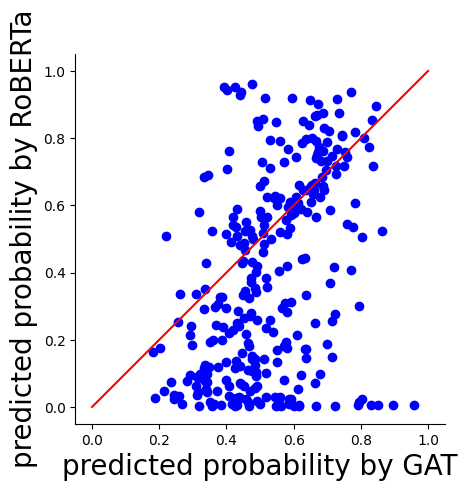

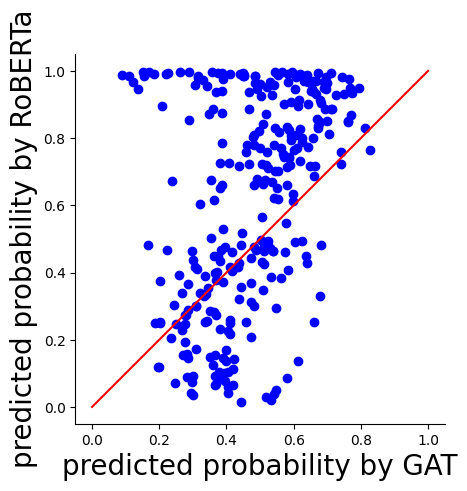

In [9]:
#genearte figure 3
x1=np.array(df[(df.truth_rand==0) & (df.vali==1)].predicted_HAN_neg)
x2=np.array(df[(df.truth_rand==0) & (df.vali==1)].predicted_BERT_neg)

x3=np.array(df[(df.truth_rand==1) & (df.vali==1)].predicted_HAN_pos)
x4=np.array(df[(df.truth_rand==1) & (df.vali==1)].predicted_BERT_pos)

x1=np.array(df[(df.truth_rand==0) & (df.vali==1)].pred_han_neg_norm)
x2=np.array(df[(df.truth_rand==0) & (df.vali==1)].pred_bert_neg_norm)

x3=np.array(df[(df.truth_rand==1) & (df.vali==1)].pred_han_pos_norm)
x4=np.array(df[(df.truth_rand==1) & (df.vali==1)].pred_bert_pos_norm)


import matplotlib
import matplotlib.pyplot as plt
import numpy

os.chdir(path_result)

fig = plt.figure()
#ax = fig.add_subplot()
l1=[0,1]
#plt.plot(x2, x1)
matplotlib.pyplot.plot(x1, x2, 'bo')
matplotlib.pyplot.plot(l1, l1, 'r-')
print(numpy.corrcoef(x1, x2)[0, 1])
#matplotlib.pyplot.set_aspect('equal', 'box')
#.pyplot.gca().set_aspect('equal')
matplotlib.pyplot.axis('square')
matplotlib.pyplot.gca().spines['top'].set_visible(False)
matplotlib.pyplot.gca().spines['right'].set_visible(False)
plt.xlabel("predicted probability by GAT", fontsize=20)
plt.ylabel("predicted probability by RoBERTa", fontsize=20)
#ax.text(0.8, 0.1, 'Corr='+str(np.round(numpy.corrcoef(x1, x2)[0, 1],4)),bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
matplotlib.pyplot.savefig('plot3.png', dpi=300, bbox_inches='tight')


fig = plt.figure()
#ax = fig.add_subplo3t()
matplotlib.pyplot.plot(x3, x4, 'bo')
matplotlib.pyplot.plot(l1, l1, 'r-')
print(numpy.corrcoef(x3, x4)[0, 1])
matplotlib.pyplot.axis('square')
matplotlib.pyplot.gca().spines['top'].set_visible(False)
matplotlib.pyplot.gca().spines['right'].set_visible(False)
plt.xlabel("predicted probability by GAT", fontsize=20)
plt.ylabel("predicted probability by RoBERTa", fontsize=20)
#ax.text(0.8, 0.1, 'Corr='+str(np.round(numpy.corrcoef(x3, x4)[0, 1],4)),bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
matplotlib.pyplot.savefig('plot4.png', dpi=300, bbox_inches='tight')

In [49]:
a

array([], shape=(0, 2), dtype=float64)

In [64]:
#Using logistic regression to get prediction
#RUN PREVIOUS CODE BEFORE RUNNIGN THIS ONE
#copy paste regression coefficient to step 5 notebook

# split into train/test sets
trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==0)]['pred_bert_pos_norm'],dtype=float))))
testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==1)]['pred_bert_pos_norm'],dtype=float))))
trainy=np.array(df.loc[(df.vali==0)]['truth_rand'],dtype=float)
testy =np.array(df.loc[(df.vali==1)]['truth_rand'],dtype=float)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
print([model.intercept_,model.coef_])
w=(model.coef_[0])
weights=[]
pred=[]
for s in schoolyears:
    # split into train/test sets
    trainX=np.transpose(np.vstack((np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    testX=np.transpose(np.vstack((np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    trainy=np.array(df.loc[(df.vali==0) & (df.schoolyear==s)]['truth_rand'],dtype=float)
    testy =np.array(df.loc[(df.vali==1) & (df.schoolyear==s)]['truth_rand'],dtype=float)
    # fit a model
    #model = LogisticRegression(solver='lbfgs')#,fit_intercept=False)
    #model.fit(trainX, trainy)
    a=np.transpose(np.vstack((np.array(df.loc[(df.schoolyear==s)]['pred_han_pos_norm'],dtype=float), 
                              np.array(df.loc[(df.schoolyear==s)]['pred_bert_pos_norm'],dtype=float))))
    # print(a.shape)
    # if (a.shape[0] == 0):
    #     print("empty!")
    #     a = np.array([0, 0]).reshape(0, 2)
    pred+=(list(model.predict(a)))

[array([0.12852661]), array([[-0.28334371,  0.00781942]])]


In [72]:
#RUN PREVIOUS CODE BEFORE THIS ONE 
#get testing result

path_result='C:\\Users\\yunfa\\dsc180b\\results'
path_data="C:\\Users\\yunfa\\dsc180b\\data"
path_code="C:\\Users\\yunfa\\dsc180b"
path_temp="C:\\Users\\yunfa\\dsc180b\\temp"

import numpy as np 
import urllib.request 
import os 
import csv 
import requests 
import time
import math
import pandas as pd
from collections import defaultdict
import pickle
import re, string, unicodedata
from string import punctuation
import heapq
import pickle
import warnings
#from keras.preprocessing.sequence import pad_sequences
import random
from sklearn.utils import shuffle
#import tensorflow_hub as hub
#import tensorflow_text

filepath=path_result
filepath2=path_data
filepath3=path_data
path=path_data
os.chdir(filepath)

types=["comment"]
years=['2019','2020']
#years=['2020']
schools = ["notredame","uofm","columbia","UCSD","berkeley","Harvard","ucla"]
categ={"notredame":[1,1,1],"uofm":[1,1,0],"columbia":[1,0,1],"dartmouth":[0,1,1],
       "UCSD":[1,0,0],"berkeley":[0,1,0],"Harvard":[0,0,1],"ucla":[0,0,0]}

#Positive: 1, negative:0
#2020:1, 2019:0
label_group=["label"]#,"unlabel"]
months=['08','09','10','11']

att_com=['time','id','body','Emotion','emo_pred']
drop_com=["link_id",'Topic',"parent_id","author_fullname","author","gildings","score","subreddit","no_follow","total_awards_received","all_awardings","is_submitter","locked","send_replies","stickied",]
emo=["Very Positive","Positive","Neutral","Negative","Very negative"]
top=["Covid","Academics","Sports","Campus/Students Life","Social Media","Religion","Politics","Others"]

TP_HAN=[]
TN_HAN=[]
CR_HAN=[]
Pre_HAN=[]
Rec_HAN=[]
Spe_HAN=[]

TP_BERT=[]
TN_BERT=[]
CR_BERT=[]
Pre_BERT=[]
Rec_BERT=[]
Spe_BERT=[]
      
        
#Find labels from probability for three methods
df['pred_esm']=0
df['pred_HAN']=0
df['pred_BERT']=0

#Remove: "notredame2019","notredame2020","dartmouth"
schoolyears=["uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020"]
      

#Analyse for classification rate for testing set

for d in range(len(df['schoolyear'])):
    negHAN=df['pred_han_neg_norm'].iloc[d]
    posHAN=df['pred_han_pos_norm'].iloc[d]
    negBERT=df['pred_bert_neg_norm'].iloc[d]
    posBERT=df['pred_bert_pos_norm'].iloc[d]
    
    if posHAN>=0.5:
        #df['pred_HAN'].iloc[d]=0
        df.iloc[d, df.columns.get_loc('pred_HAN')] =1
    elif posHAN<=0.5:
        #df['pred_HAN'].iloc[d]=1
        df.iloc[d, df.columns.get_loc('pred_HAN')] =0
    if posBERT>=0.5:
        #df['pred_BERT'].iloc[d]=0
        df.iloc[d, df.columns.get_loc('pred_BERT')] =1
    elif posBERT<=0.5:
        #df['pred_BERT'].iloc[d]=1
        df.iloc[d, df.columns.get_loc('pred_BERT')] =0
        
    df.iloc[d, df.columns.get_loc('pred_esm')]=pred[d]
    
CR_HAN=[]
CR_BERT=[]
CR_esm=[]
    
F1_HAN=[]
F1_BERT=[]
F1_esm=[]

Pre_HAN=[]
Pre_BERT=[]
Pre_esm=[]

Rec_HAN=[]
Rec_BERT=[]
Rec_esm=[]

Spe_HAN=[]
Spe_BERT=[]
Spe_esm=[]
    
for s in schoolyears:
    CR_esm.append(sum(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']==df.loc[(df.schoolyear==s) & (df.vali==k)]['pred_esm'])/len(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']))
    CR_BERT.append(sum(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']==df.loc[(df.schoolyear==s) & (df.vali==k)]['pred_BERT'])/len(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']))
    CR_HAN.append(sum(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']==df.loc[(df.schoolyear==s) & (df.vali==k)]['pred_HAN'])/len(df.loc[(df.schoolyear==s) & (df.vali==k)]['truth_rand']))
        
    #calculation for HAN
    Predicted_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==0)]['schoolyear'])
    Predicted_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==1)]['schoolyear'])
    Truth_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==0)]['schoolyear'])
    Truth_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==1)]['schoolyear'])
            
    False_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==0)]['schoolyear'])
    False_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==1)]['schoolyear'])
    True_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==1)]['schoolyear'])
    True_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==0)]['schoolyear'])
    
    Pre_HAN.append(True_Pos/Predicted_Pos)
    Rec_HAN.append(True_Pos/Truth_Pos)
    Spe_HAN.append(True_Neg/Truth_Neg)
    
    #calculation for BERT
    Predicted_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==0)]['schoolyear'])
    Predicted_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==1)]['schoolyear'])
    Truth_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==0)]['schoolyear'])
    Truth_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==1)]['schoolyear'])
            
    False_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==0)]['schoolyear'])
    False_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==1)]['schoolyear'])
    True_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==1)]['schoolyear'])
    True_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==0)]['schoolyear'])
    
    Pre_BERT.append(True_Pos/Predicted_Pos)
    Rec_BERT.append(True_Pos/Truth_Pos)
    Spe_BERT.append(True_Neg/Truth_Neg)
    
    #calculation for esm
    Predicted_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==0)]['schoolyear'])
    Predicted_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==1)]['schoolyear'])
    Truth_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==0)]['schoolyear'])
    Truth_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.truth_rand==1)]['schoolyear'])
            
    False_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==1) & (df.truth_rand==0)]['schoolyear'])
    False_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==0) & (df.truth_rand==1)]['schoolyear'])
    True_Pos=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==1) & (df.truth_rand==1)]['schoolyear'])
    True_Neg=len(df.loc[(df.schoolyear==s) & (df.vali==k) & (df.pred_esm==0) & (df.truth_rand==0)]['schoolyear'])
    
    Pre_esm.append(True_Pos/Predicted_Pos)
    Rec_esm.append(True_Pos/Truth_Pos)
    Spe_esm.append(True_Neg/Truth_Neg)

CR_esm.append(sum(df.loc[(df.vali==k)]['truth_rand']==df.loc[(df.vali==k)]['pred_esm'])/len(df.loc[(df.vali==k)]['truth_rand']))
CR_BERT.append(sum(df.loc[(df.vali==k)]['truth_rand']==df.loc[(df.vali==k)]['pred_BERT'])/len(df.loc[(df.vali==k)]['truth_rand']))
CR_HAN.append(sum(df.loc[(df.vali==k)]['truth_rand']==df.loc[(df.vali==k)]['pred_HAN'])/len(df.loc[(df.vali==k)]['truth_rand']))

#calculation for HAN
Predicted_Neg=len(df.loc[(df.vali==k) & (df.pred_HAN==0)]['schoolyear'])
Predicted_Pos=len(df.loc[(df.vali==k) & (df.pred_HAN==1)]['schoolyear'])
Truth_Neg=len(df.loc[(df.vali==k) & (df.truth_rand==0)]['schoolyear'])
Truth_Pos=len(df.loc[(df.vali==k) & (df.truth_rand==1)]['schoolyear'])

False_Pos=len(df.loc[(df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==0)]['schoolyear'])
False_Neg=len(df.loc[(df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==1)]['schoolyear'])
True_Pos=len(df.loc[(df.vali==k) & (df.pred_HAN==1) & (df.truth_rand==1)]['schoolyear'])
True_Neg=len(df.loc[(df.vali==k) & (df.pred_HAN==0) & (df.truth_rand==0)]['schoolyear'])

Pre_HAN.append(True_Pos/Predicted_Pos)
Rec_HAN.append(True_Pos/Truth_Pos)
Spe_HAN.append(True_Neg/Truth_Neg)

#calculation for BERT
Predicted_Neg=len(df.loc[(df.vali==k) & (df.pred_BERT==0)]['schoolyear'])
Predicted_Pos=len(df.loc[(df.vali==k) & (df.pred_BERT==1)]['schoolyear'])
Truth_Neg=len(df.loc[(df.vali==k) & (df.truth_rand==0)]['schoolyear'])
Truth_Pos=len(df.loc[(df.vali==k) & (df.truth_rand==1)]['schoolyear'])

False_Pos=len(df.loc[(df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==0)]['schoolyear'])
False_Neg=len(df.loc[(df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==1)]['schoolyear'])
True_Pos=len(df.loc[(df.vali==k) & (df.pred_BERT==1) & (df.truth_rand==1)]['schoolyear'])
True_Neg=len(df.loc[(df.vali==k) & (df.pred_BERT==0) & (df.truth_rand==0)]['schoolyear'])

Pre_BERT.append(True_Pos/Predicted_Pos)
Rec_BERT.append(True_Pos/Truth_Pos)
Spe_BERT.append(True_Neg/Truth_Neg)

#calculation for esm
Predicted_Neg=len(df.loc[(df.vali==k) & (df.pred_esm==0)]['schoolyear'])
Predicted_Pos=len(df.loc[(df.vali==k) & (df.pred_esm==1)]['schoolyear'])
Truth_Neg=len(df.loc[(df.vali==k) & (df.truth_rand==0)]['schoolyear'])
Truth_Pos=len(df.loc[(df.vali==k) & (df.truth_rand==1)]['schoolyear'])

False_Pos=len(df.loc[(df.vali==k) & (df.pred_esm==1) & (df.truth_rand==0)]['schoolyear'])
False_Neg=len(df.loc[(df.vali==k) & (df.pred_esm==0) & (df.truth_rand==1)]['schoolyear'])
True_Pos=len(df.loc[(df.vali==k) & (df.pred_esm==1) & (df.truth_rand==1)]['schoolyear'])
True_Neg=len(df.loc[(df.vali==k) & (df.pred_esm==0) & (df.truth_rand==0)]['schoolyear'])

Pre_esm.append(True_Pos/Predicted_Pos)
Rec_esm.append(True_Pos/Truth_Pos)
Spe_esm.append(True_Neg/Truth_Neg)

F1_HAN=2*np.divide(np.multiply(Pre_HAN,Rec_HAN),np.add(Pre_HAN,Rec_HAN))
F1_BERT=2*np.divide(np.multiply(Pre_BERT,Rec_BERT),np.add(Pre_BERT,Rec_BERT))
F1_esm=2*np.divide(np.multiply(Pre_esm,Rec_esm),np.add(Pre_esm,Rec_esm))




In [74]:
dat.shape

[['CR',
  'HAN',
  '0.58',
  '0.48',
  '0.5',
  '0.56',
  '0.5',
  '0.4',
  '0.54',
  '0.4',
  '0.46',
  '0.48',
  '0.48',
  '0.6',
  '0.49833333333333335'],
 ['CR',
  'BERT',
  '0.56',
  '0.5',
  '0.46',
  '0.56',
  '0.52',
  '0.46',
  '0.64',
  '0.44',
  '0.42',
  '0.48',
  '0.46',
  '0.46',
  '0.49666666666666665'],
 ['CR',
  'esm',
  '0.42',
  '0.5',
  '0.5',
  '0.5',
  '0.52',
  '0.64',
  '0.48',
  '0.52',
  '0.56',
  '0.48',
  '0.54',
  '0.4',
  '0.505'],
 ['F1',
  'HAN',
  '0.5882352941176471',
  '0.40909090909090906',
  '0.4897959183673469',
  '0.5217391304347826',
  '0.5098039215686274',
  '0.37499999999999994',
  '0.48888888888888893',
  '0.4444444444444445',
  '0.4255319148936171',
  '0.38095238095238104',
  '0.5',
  '0.6153846153846153',
  '0.48192771084337344'],
 ['F1',
  'BERT',
  '0.6071428571428571',
  '0.4444444444444445',
  '0.49056603773584906',
  '0.5925925925925927',
  '0.5555555555555556',
  '0.5263157894736842',
  '0.6538461538461539',
  '0.4615384615384615',
  '

In [75]:
# run previous one before running this one 
#save prediction results in file "figure4"
#Remove:"notredame2019","notredame2020","dartmouth"
sc=['metric','method',"uofm2019","uofm2020","columbia2019","columbia2020","UCSD2019","UCSD2020","berkeley2019","berkeley2020","Harvard2019","Harvard2020","ucla2019","ucla2020",'overall']

dat=[['CR']+['HAN']+[str(c) for c in CR_HAN]]
line=['CR']+['BERT']+[str(c) for c in CR_BERT];dat.append(line);
line=['CR']+['esm']+[str(c) for c in CR_esm];dat.append(line);

line=['F1']+['HAN']+[str(c) for c in F1_HAN];dat.append(line);
line=['F1']+['BERT']+[str(c) for c in F1_BERT];dat.append(line);
line=['F1']+['esm']+[str(c) for c in F1_esm];dat.append(line);

line=['Pre']+['HAN']+[str(c) for c in Pre_HAN];dat.append(line);
line=['Pre']+['BERT']+[str(c) for c in Pre_BERT];dat.append(line);
line=['Pre']+['esm']+[str(c) for c in Pre_esm];dat.append(line);

line=['Rec']+['HAN']+[str(c) for c in Rec_HAN];dat.append(line);
line=['Rec']+['BERT']+[str(c) for c in Rec_BERT];dat.append(line);
line=['Rec']+['esm']+[str(c) for c in Rec_esm];dat.append(line);

line=['Spe']+['HAN']+[str(c) for c in Spe_HAN];dat.append(line);
line=['Spe']+['BERT']+[str(c) for c in Spe_BERT];dat.append(line);
line=['Spe']+['esm']+[str(c) for c in Spe_esm];dat.append(line);

#print(dat)
dff=pd.DataFrame(dat,columns=sc)
os.chdir(path_result)
dff.to_csv(path_result+'figure4.csv', index = False, header=True)
print(dff)

   metric method             uofm2019             uofm2020  \
0      CR    HAN                 0.58                 0.48   
1      CR   BERT                 0.56                  0.5   
2      CR    esm                 0.42                  0.5   
3      F1    HAN   0.5882352941176471  0.40909090909090906   
4      F1   BERT   0.6071428571428571   0.4444444444444445   
5      F1    esm  0.35555555555555557   0.5454545454545454   
6     Pre    HAN   0.5769230769230769  0.47368421052631576   
7     Pre   BERT   0.5483870967741935                  0.5   
8     Pre    esm                  0.4                  0.5   
9     Rec    HAN                  0.6                 0.36   
10    Rec   BERT                 0.68                  0.4   
11    Rec    esm                 0.32                  0.6   
12    Spe    HAN                 0.56                  0.6   
13    Spe   BERT                 0.44                  0.6   
14    Spe    esm                 0.52                  0.4   

       

In [77]:
#format it to table
#the sequence of methods are gat, bert, ens, which are different from paper
#change the sequence you copy paste

dff=dff.reset_index()
# dff['dartmouth2019']=dff['dartmouth']
# dff['dartmouth2020']=''
dff['overall2019']=dff['overall']
dff['overall2020']=''
metrics=['CAR\\textsuperscript{*} ','F1\\textsuperscript{$\\dagger$} ','specificity ',
        'precision\\textsuperscript{$\\ddagger$} ','recall\\textsuperscript{${\\dagger\\dagger}$} ']
metric_name=['CR',"F1",'Pre',"Rec",'Spe']
years=['2019','2020']
methods=['GAT','bert','ens']
#remove: ,"dartmouth2019","notredame2019"
schoolyears2019=["ucla2019","UCSD2019","berkeley2019","uofm2019","Harvard2019","columbia2019",'overall2019']
#remove: ,"dartmouth2020","notredame2020"
schoolyears2020=["ucla2020","UCSD2020","berkeley2020","uofm2020","Harvard2020","columbia2020",'overall2020']

for me in range(len(methods)):
    id=me-3
    for m in range(len(metrics)):
        id+=3
        for y in years:
            if y=='2019':
                line=metrics[m]+'& 2019 '
                for s in schoolyears2019:
                    if len(dff[s][m])>0:
                        new='{:.3f}'.format(round(float(dff[s][id]), 3))
                    else:
                        new=''
                    line=line+'& '+new
            elif y=='2020':
                line='    & 2020 '
                for s in schoolyears2020:
                    if len(dff[s][m])>0:
                        new='{:.3f}'.format(round(float(dff[s][id]), 3))
                    else:
                        new=''
                    line=line+'& '+new
            line=line+'\\\\'
            print(line)
            

CAR\textsuperscript{*} & 2019 & 0.480& 0.500& 0.540& 0.580& 0.460& 0.500& 0.498\\
    & 2020 & 0.600& 0.400& 0.400& 0.480& 0.480& 0.560& \\
F1\textsuperscript{$\dagger$} & 2019 & 0.500& 0.510& 0.489& 0.588& 0.426& 0.490& 0.482\\
    & 2020 & 0.615& 0.375& 0.444& 0.409& 0.381& 0.522& \\
specificity & 2019 & 0.481& 0.500& 0.550& 0.577& 0.455& 0.500& 0.498\\
    & 2020 & 0.593& 0.391& 0.414& 0.474& 0.471& 0.571& \\
precision\textsuperscript{$\ddagger$} & 2019 & 0.520& 0.520& 0.440& 0.600& 0.400& 0.480& 0.467\\
    & 2020 & 0.640& 0.360& 0.480& 0.360& 0.320& 0.480& \\
recall\textsuperscript{${\dagger\dagger}$} & 2019 & 0.440& 0.480& 0.640& 0.560& 0.520& 0.520& 0.530\\
    & 2020 & 0.560& 0.440& 0.320& 0.600& 0.640& 0.640& \\
CAR\textsuperscript{*} & 2019 & 0.460& 0.520& 0.640& 0.560& 0.420& 0.460& 0.497\\
    & 2020 & 0.460& 0.460& 0.440& 0.500& 0.480& 0.560& \\
F1\textsuperscript{$\dagger$} & 2019 & 0.526& 0.556& 0.654& 0.607& 0.491& 0.491& 0.534\\
    & 2020 & 0.526& 0.526& 0.462& 0.444&